# ETS Forecasting in aeon


Experimental functions. Note Im not sure the 

In [1]:
import traceback

import numpy as np
import pandas as pd
from aeon.forecasting.stats import AutoETS as AeonAutoETS
from aeon.forecasting.stats import ETS as AeonETS
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from aeon_benchmark.forecasting.arima import make_statsforecast_df
from statsforecast import StatsForecast
from statsforecast.models import AutoETS as SF_AutoETS
import warnings

from aeon_benchmark.forecasting.ets import make_ets_benchmark_presets, simulate_ets
warnings.filterwarnings("ignore")
import time, os
import matplotlib.pyplot as plt
import seaborn as sns

def compare_ets_forecasters(lengths, sigma=1.0, seed_base=0):
    """
    Compare forecasters over increasing serlsies lengths.

    Parameters
    ----------
    lengths : list of int
        Series lengths to evaluate.
    m : int
        Repetitions per length.
    sigma : float
        Std dev of noise in simulated data.
    seed_base : int
        Base seed to ensure reproducibility.

    Returns
    -------
    pandas.DataFrame
        Average MSE and time per method per length.
    """
    results = []
    # Warm up for numba
    n = 100
    presets = make_ets_benchmark_presets()
    y = simulate_ets(presets[0], n=100, burnin=100, seed=seed_base)
    aeon_model = AeonETS().fit(y)
    aeon_auto_model = AeonAutoETS().fit(y)
    df = make_statsforecast_df(y)
    modelString = presets[0].error + ('A' if presets[0].trend == 'Ad' else presets[0].trend) + presets[0].seasonal
    damped = presets[0].trend == 'Ad'
    sf = StatsForecast(models=[SF_AutoETS(season_length=presets[0].m, model=modelString, damped=damped)], freq="H")
    forecast_df = sf.forecast(df=df, h=1)
    forecast = forecast_df.iloc[0]["AutoETS"]

    for n in lengths:
        print(" Beginning length ",n)
        for i in range(len(presets)):
            for j in range(10):
                seed = seed_base + i + j * 100 + n * 1000

                # Generate parameters and data
                modelString = presets[i].error + ('A' if presets[i].trend == 'Ad' else presets[i].trend) + presets[i].seasonal
                damped = presets[i].trend == 'Ad'
                error_type = 'multiplicative' if presets[i].error == 'M' else 'additive'
                trend_type = 'multiplicative' if presets[i].trend== 'M' else 'additive' if presets[i].trend== 'A' or presets[i].trend== 'Ad' else None
                seasonality_type = 'multiplicative' if presets[i].seasonal == 'M' else 'additive' if presets[i].seasonal== 'A' else None
                seasonal_period = presets[i].m
                y = simulate_ets(presets[i], n=n, burnin=n, seed=seed)
                y_train = y[:-1]
                y_test = y[-1:]
                # --- Statsmodels ---
                try:
                    t0 = time.time()
                    statsmodels = ETSModel(
                        y_train,
                        error=error_type,
                        trend=trend_type,
                        damped_trend=damped,
                        seasonal=seasonality_type,
                        seasonal_periods=seasonal_period if seasonal_period > 1 else None,
                    ).fit()
                    sm_forecast = statsmodels.forecast(1)
                    t1 = time.time()
                    error = y_test[0] - sm_forecast
                    sm_mse = float(error ** 2)
                    results.append({"method": 'statsmodels_true', "n": n, "mse": sm_mse, "time": t1-t0,"model": [error_type, trend_type, seasonality_type, seasonal_period]})
                except Exception as e:
                    print("Stats models exception =  ",e)
                # --- Statsforecast TRUE---
                try:
                    df = make_statsforecast_df(y_train)
                    t0 = time.time()
                    sf_true = StatsForecast(models=[SF_AutoETS(season_length=seasonal_period, model=modelString, damped=damped)],
                                        freq="H")
                    forecast_df = sf_true.forecast(df=df, h=1)
                    sf_forecast = forecast_df.iloc[0]["AutoETS"]
                    t1 = time.time()
                    error = y_test[0] - sf_forecast
                    sf_mse = float(error ** 2)
                    results.append({"method": 'statsforecast_true', "n": n, "mse": sf_mse, "time": t1-t0,"model": [error_type, trend_type, seasonality_type, seasonal_period]})
                except Exception as e:
                    print("Stats forecast exception =  ",e)
                # --- Statsforecast AUTO---
                try:
                    df = make_statsforecast_df(y_train)
                    t0 = time.time()
                    sf = StatsForecast(models=[SF_AutoETS()], freq="H")
                    forecast_df = sf.forecast(df=df, h=1)
                    sf_auto_forecast = forecast_df.iloc[0]["AutoETS"]
                    t1 = time.time()
                    error = y_test[0] - sf_auto_forecast
                    mse = float(error ** 2)
                    results.append({"method": 'statsforecast_auto', "n": n, "mse": mse, "time": t1-t0,"model": [error_type, trend_type, seasonality_type, seasonal_period]})
                except Exception as e:
                    print("Stats forecast exception =  ",e)
                # --- Aeon TRUE ---
                try:
                    t0 = time.time()
                    aeon_model = AeonETS(error_type, trend_type, seasonality_type, seasonal_period)
                    forecast = aeon_model.forecast(y_train)
                    t1 = time.time()
                    error = y_test[0] - forecast
                    aeon_mse = float(error ** 2)
                    results.append({"method": 'aeon_true', "n": n, "mse": aeon_mse, "time": t1-t0,"model": [error_type, trend_type, seasonality_type, seasonal_period]})
                    if (aeon_mse-sf_mse)>50:
                        print("Occasionally Nelder-Mead fails terribly")
                        names  = statsmodels.model.param_names          # e.g. ['smoothing_level','smoothing_trend',...]
                        values = statsmodels.params                      # ndarray of estimates (same order)
                        params = dict(zip(names, values))
                        alpha  = params.get("smoothing_level")
                        beta   = params.get("smoothing_trend")
                        gamma  = params.get("smoothing_seasonal")
                        phi    = params.get("damping_trend")
                        l0     = params.get("initial_level")
                        b0     = params.get("initial_trend")
                        s0     = [params.get(f"initial_seasonal.{i}") for i in range (seasonal_period)]
                        print({"method": 'aeon_true', "n": n, "y_true": y_test[0], "forecast": forecast, "mse": aeon_mse, "sf_forecast": sf_forecast, "sm_forecast":sm_forecast, "sf_mse": sf_mse, "sm_mse": sm_mse, "time": t1-t0, "sf_model": sf_true.models[0].model, "modeString": modelString,"model": [error_type, trend_type, seasonality_type, seasonal_period]})
                        print({"sm_params":{"alpha":alpha,"beta": beta, "gamma": gamma, "phi": phi, "l0":l0, "b0": b0, "s0": s0}})
                        print({"aeon_params":{"alpha":aeon_model.alpha_,"beta": aeon_model.beta_, "gamma": aeon_model.gamma_, "phi": aeon_model.phi_, "level": aeon_model.level_, "trend": aeon_model.trend_, "seasonality": aeon_model.seasonality_}})
                except Exception as e:
                    print("aeon forecast exception =  ",e)
                    traceback.print_exc()
                # --- Aeon AUTO---
                try:
                    t0 = time.time()
                    aeon_model = AeonAutoETS()
                    forecast = aeon_model.forecast(y_train)
                    t1 = time.time()
                    error = y_test[0] - forecast
                    mse = float(error ** 2)
                    results.append({"method": 'aeon_auto', "n": n, "mse": mse, "time": t1-t0,"model": [error_type, trend_type, seasonality_type, seasonal_period]})
                    if (mse-sf_mse)>50:
                        print("Occasionally Nelder-Mead fails terribly")
                        print({"method": 'aeon_auto', "n": n, "mse": mse, "time": t1-t0,"aeon_model": aeon_model.wrapped_model_._model, "model": [error_type, trend_type, seasonality_type, seasonal_period]})
                except Exception as e:
                    print("auto_aeon forecast exception =  ",e)
                    traceback.print_exc()
    df_results = pd.DataFrame(results)
    return df_results

def plot_mse_and_runtime_by_library(df_results):
    """
    Plot MSE and total runtime for each library (statsmodels, statsforecast, aeon),
    separately for true and baseline models. Also print tables comparing
    statsforecast and aeon against statsmodels.

    Parameters
    ----------
    df_results : pd.DataFrame
        Must contain columns: ['method', 'n', 'mse', 'time']
    """
    sns.set(style="whitegrid", font_scale=1.2)
    df = df_results.copy()

    # Extract library and model type (true or baseline)
    df["library"] = df["method"].str.extract(r"^(statsforecast|statsmodels|aeon)")
    df["model_type"] = df["method"].str.extract(r"_(true|auto)")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

    for i, (metric, agg) in enumerate([("mse", "mean"), ("time", "sum")]):
        for j, model_type in enumerate(["true", "auto"]):
            ax = axes[i, j]
            data = df[df["model_type"] == model_type]

            summary = data.groupby(["library", "n"]).agg(
                mean=(metric, agg),
                std=(metric, "std")
            ).reset_index()

            sns.lineplot(
                data=summary,
                x="n",
                y="mean",
                hue="library",
                marker="o",
                err_style="band",
                err_kws={"alpha": 0.2},
                ax=ax
            )

            label = "Mean Squared Error" if metric == "mse" else "Total Runtime (seconds)"
            ax.set_title(f"{label} vs n ({model_type} models)")
            ax.set_xlabel("Series Length (n)")
            ax.set_ylabel(label)
            if metric == "time":
                ax.set_yscale("log")
            ax.grid(True)
            ax.legend(title="Library")

    plt.tight_layout()
    plt.show()




c:\dev\aeon\venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


# Basic experiment

In [2]:

results = compare_ets_forecasters(lengths=[200, 300, 400, 500, 600, 700, 800, 900, 1000],
                                    sigma=1.0, seed_base=0)

 Beginning length  200
Occasionally Nelder-Mead fails terribly
{'method': 'aeon_true', 'n': 200, 'y_true': np.float64(1285.081869093741), 'forecast': 1273.7128085069476, 'mse': 129.2555386261806, 'sf_forecast': np.float64(1282.7466004771757), 'sm_forecast': array([1285.15912228]), 'sf_mse': 5.453479511515147, 'sm_mse': 0.0059680545967572595, 'time': 0.001976490020751953, 'sf_model': 'AAA', 'modeString': 'AAA', 'model': ['additive', 'additive', 'additive', 12]}
{'sm_params': {'alpha': np.float64(0.1926490218931409), 'beta': np.float64(0.14049807691526112), 'gamma': np.float64(8.073509781068591e-05), 'phi': None, 'l0': np.float64(328.0162948459361), 'b0': np.float64(3.0665492955697036), 's0': [np.float64(0.4311354044278851), np.float64(0.11020069339156763), np.float64(0.08145183894365937), np.float64(-0.03448485341212645), np.float64(-0.021603379625170824), np.float64(-0.16215614706387904), np.float64(-0.5643649822439311), np.float64(0.6798375957775732), np.float64(0.008360953067863818),

In [3]:
from aeon.forecasting.utils._loss_functions import _ets_aic
import numpy as np
params = np.array([0.2, 0.7])
model = np.array([1, 0, 2, 3])
data = [ 6.53523974,  6.75267761,  6.46621745,  5.72880496,  5.95803673,  7.39575729,
  5.45136943,  5.43292246,  6.0826154 ,  7.55667126,  7.23884718,  5.32638595,
  5.53455303,  6.86044134,  6.68737769,  7.46712866,  6.73620948,  5.7330165,
  6.7543424 ,  7.49706784,  6.130847  ,  6.28598392,  8.06218438,  6.52952522,
  6.3839989 ,  6.85542744,  6.57563372,  6.56093298,  6.55368466,  5.46783131,
  8.74261628,  5.30281087,  5.0055628 ,  6.91243816,  5.44123881,  6.13485707,
  6.15378431,  8.26060546,  6.12720865,  5.0467798 ,  6.34578272,  5.27273021,
  6.75171801,  7.21316841,  6.49970814,  7.53156568,  6.26331027,  7.51974295,
  7.41066067,  7.0953707 ,  5.07558014,  5.71446876,  7.56147341,  6.70793574,
  4.66069558,  6.10489629,  9.06002364,  9.88742717,  8.76762226,  6.96722075,
  7.13925924,  6.88801405,  9.15558313,  7.17383421,  7.99935378,  8.33688254,
  9.76912561,  8.84162225,  7.52675301,  7.78995429,  8.39145385,  7.73465133,
  9.43123806,  9.9833927 ,  8.34986608,  7.61691289,  8.99154054,  7.77237693,
  7.97087672,  8.15500363,  8.40027332,  8.24215215,  8.65403627, 10.13037765,
  7.26225934,  9.42389978, 10.16439178,  9.94559338, 10.82848189,  9.51986565,
 10.19368458, 11.2445023 , 10.18442414,  9.54786139, 10.60838482,  9.88708769,
 10.37050169, 10.03804564,  9.72936578, 10.94088951, 10.47889524,  9.53080637,
 11.62130897,  8.78370986,  9.96738562, 10.16307187, 10.96203   , 12.09019578,
 11.68982186,  9.46914944, 10.92589635, 11.37089432, 10.39814895, 11.31504156,
 12.58618238, 10.08972779,  9.98399752, 11.91586839, 10.18828087, 11.38420089,
 11.34547024, 11.98250535, 11.10581556,  9.98797164, 11.02035733, 10.10090926,
 11.62403833, 12.41915371, 11.84270215, 13.03763947, 13.17762438, 12.49387101,
 12.88439433, 12.48002102, 12.38484814, 11.85026382, 12.41108567, 13.27852398,
 12.60894173, 12.19733059, 12.10311434, 13.93686395, 12.13278473, 11.7191836,
 13.05111569, 12.83818001, 14.24802199, 12.1004716 , 10.86188139, 11.72486021,
 12.81719848, 11.35912467, 13.16383909, 13.71963097, 11.80307157, 13.35102334,
 10.54770732, 12.09088129, 12.72331069, 13.40972735, 11.53379949, 11.33302113,
 11.76807396, 12.13474953, 11.59900175, 12.38578487, 11.07462179, 10.75561008,
 10.62669173, 12.75228226, 12.61545318, 13.82881658, 11.92020372, 11.31106859,
 13.75590116, 11.53805997, 14.03424865, 12.77146622, 11.64605435, 12.67353725,
 11.99171792, 11.63009283, 12.21866802, 11.03820061, 11.60098029, 13.07651391,
 11.99723497, 13.2713385 , 12.39359291, 11.05837543, 11.93481928, 10.55044954,
 13.21717013, 11.70762541, 10.27538   ,  9.64154935, 11.13939938, 11.76118881,
  9.43414072]

print(_ets_aic(params, data, model))

25.088179245401957


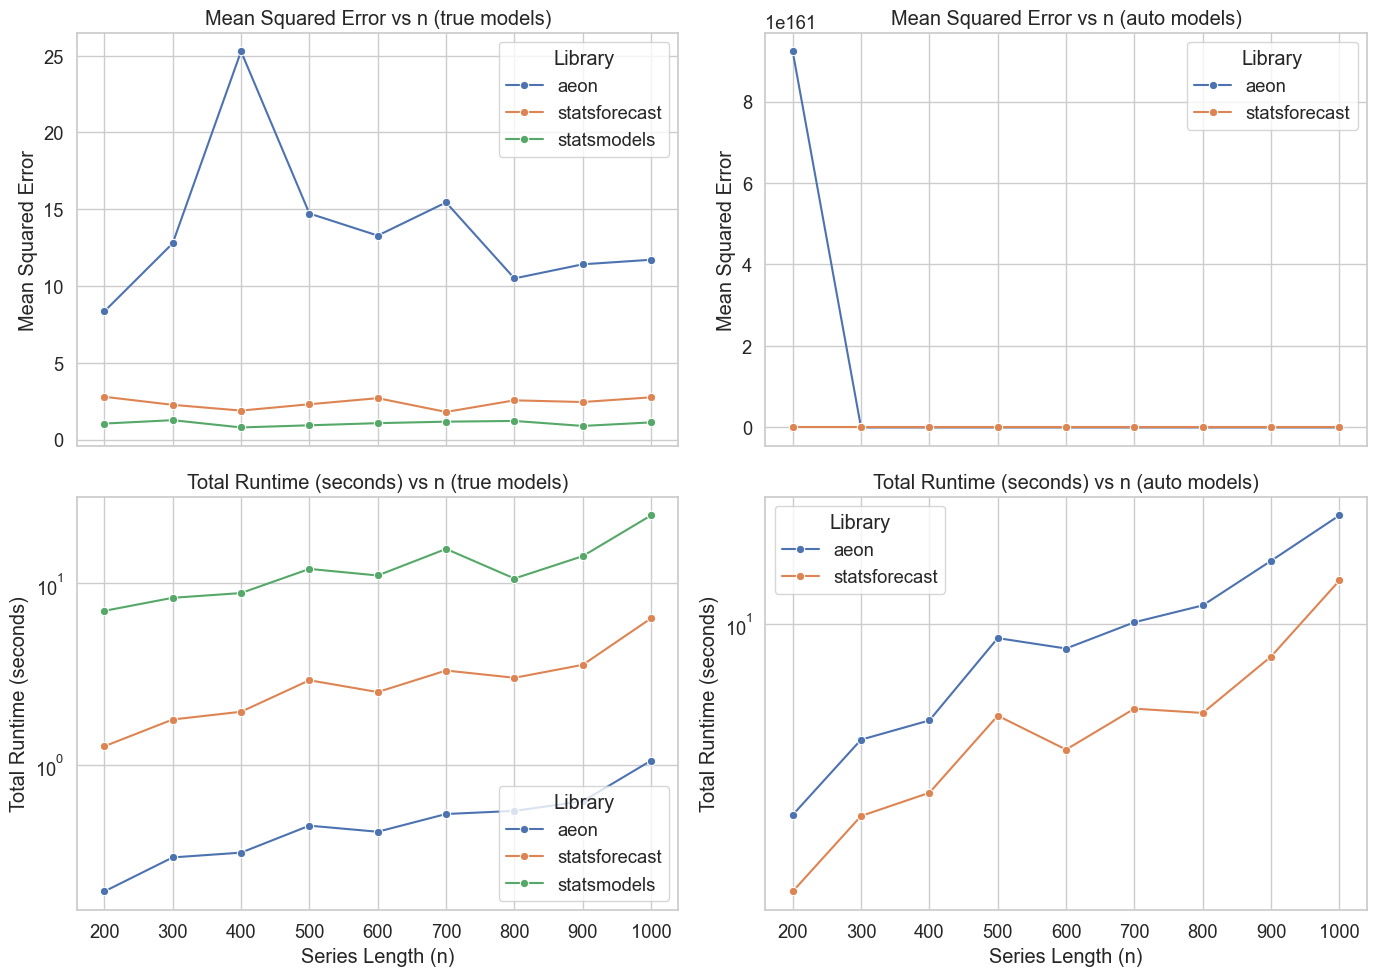

In [4]:
plot_mse_and_runtime_by_library(results)